In [848]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

## 1. Convolution and deconvolution

### Part a

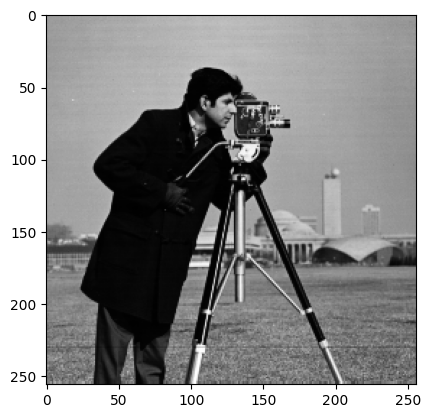

In [849]:
gray_image = plt.imread('std/Cameraman256.png')
height, width = gray_image.shape
plt.imshow(gray_image, cmap='gray')

### Part b

In [850]:
sigma = 1
theta = 0.01
alpha = 0.01

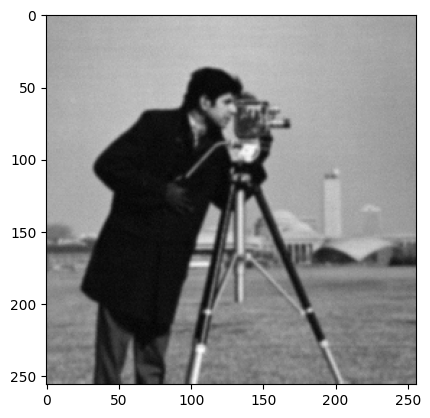

In [851]:
def blur(image, sigma=1, theta=0.01):
    g = gaussian_filter(image, sigma)
    w, h = g.shape
    g = g + theta * np.random.randn(w, h)

    return g

plt.imshow(blur(gray_image), cmap='gray')

### Part c

In [852]:
def ATA(v):
    image = v.reshape((height, width))
    y = gaussian_filter(image, sigma)
    z = gaussian_filter(y, sigma) + alpha * image

    return z.reshape(v.shape)

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

In [853]:
A = scipy.sparse.linalg.LinearOperator((height * width, height * width), ATA)
ATg = gaussian_filter(blur(gray_image, sigma, theta), sigma).reshape((height * width,))
counter = gmres_counter(disp=False)
x1c, info = scipy.sparse.linalg.gmres(A, ATg, callback=counter)

Status: 0
Iteration number: 32
L2D: 10.474262


Text(0.5, 1.0, 'Deconvolved image')

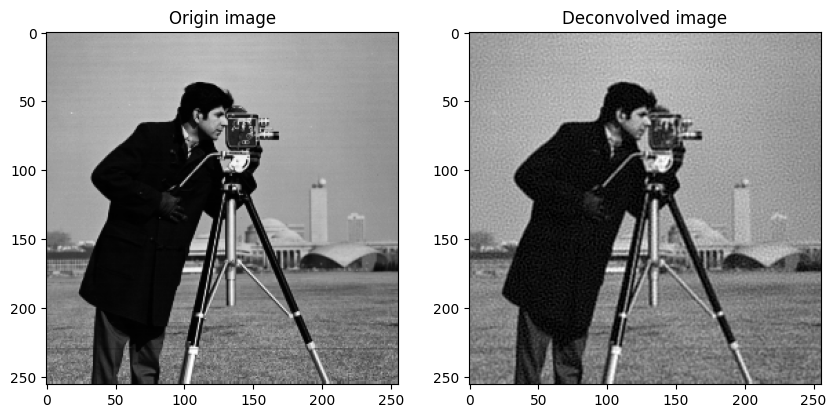

In [854]:
f_alpha = x1c.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (info, counter.niter, np.linalg.norm(f_alpha - gray_image)))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(f_alpha.clip(0, 1), cmap='gray')
ax[1].set_title('Deconvolved image')

### Part d

In [730]:
def M_f(v):
    image = v.reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(v.shape)
    z = np.hstack((y, np.sqrt(alpha) * v))

    return z

def MT_b(v):
    length = height * width
    image = v[: length].reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(length)
    z = y + np.sqrt(alpha) * v[length:]

    return z

In [731]:
u = np.random.randn(height * width)
v = np.random.randn(height * width * 2)
a = np.dot(M_f(u), v)
b = np.dot(MT_b(v), u)
print(a - b)

-3.552713678800501e-14


In [740]:
M = scipy.sparse.linalg.LinearOperator((2 * height * width, height * width), matvec=M_f, rmatvec=MT_b)
g = blur(gray_image, sigma, theta).reshape((height * width,))
b = np.hstack((g, np.zeros(g.shape)))
x_lsqr = scipy.sparse.linalg.lsqr(M, b)

Status: 2
Iteration number: 43
L2D: 10.123884


Text(0.5, 1.0, 'Deconvolved image')

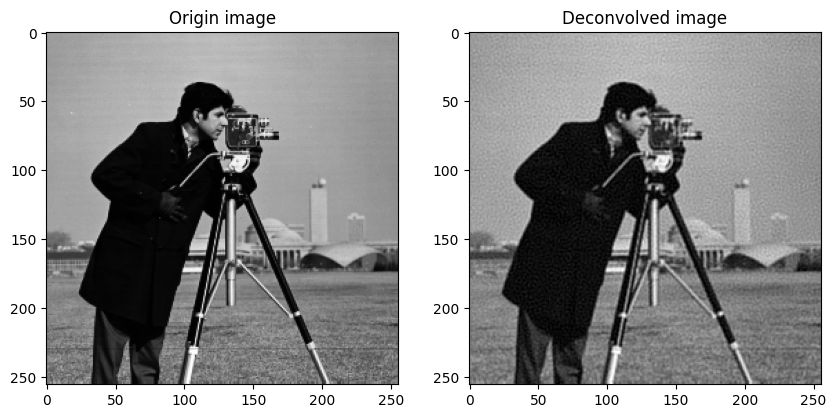

In [743]:
f = x_lsqr[0].reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (x_lsqr[1], x_lsqr[2], np.linalg.norm(f - gray_image)))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(f.clip(0, 1), cmap='gray')
ax[1].set_title('Deconvolved image')

## 2. Choose a regularisation parameter $\alpha$

### Discrepency Principle

In [602]:
A = scipy.sparse.linalg.LinearOperator((height * width, height * width), ATA)
g = blur(gray_image, sigma, theta)
ATg = gaussian_filter(g, sigma).reshape((height * width,))
def dp_alpha(a):
    global alpha
    alpha = a
    f, _ = scipy.sparse.linalg.gmres(A, ATg)
    Af = gaussian_filter(f.reshape((height, width)), sigma)
    r_alpha = g - Af.reshape(g.shape)
    nr = np.linalg.norm(r_alpha)
    
    return np.abs(nr * nr / (height * width) - theta * theta)

In [603]:
sol = scipy.optimize.minimize_scalar(dp_alpha, bounds=(1e-6, 1), method='bounded')

Converge Message: Solution found.
Optimal alpha: 0.011951
Value of DP(alpha): 7.009644e-05

Status: 0
Iteration number: 30
L2D: 10.250983


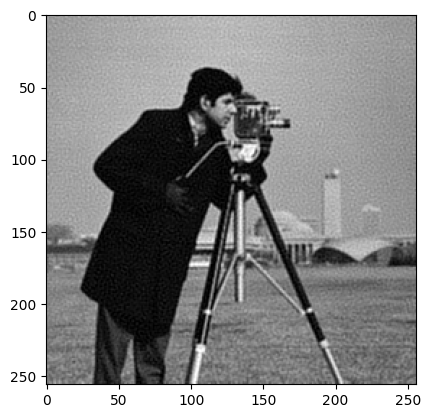

In [758]:
print('Converge Message: %s\nOptimal alpha: %.6f\nValue of DP(alpha): %.6e\n' % (sol.message, sol.x, dp_alpha(sol.x)))
alpha = sol.x
A = scipy.sparse.linalg.LinearOperator((height * width, height * width), ATA)
ATg = gaussian_filter(blur(gray_image, sigma, theta), sigma).reshape((height * width,))
counter = gmres_counter(disp=False)
x1, info = scipy.sparse.linalg.gmres(A, ATg, callback=counter)
f_alpha1 = x1.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (info, counter.niter, np.linalg.norm(f_alpha1 - gray_image)))
plt.imshow(f_alpha1.clip(0, 1), cmap='gray')

### L-Curve

In [745]:
def calLCurvePoint(a):
    global alpha
    alpha = a
    f, _ = scipy.sparse.linalg.gmres(A, ATg)
    Af = gaussian_filter(f.reshape((height, width)), sigma)
    r_alpha = g - Af.reshape(g.shape)
    nr = np.linalg.norm(r_alpha)
    nf = np.linalg.norm(f)
    nr2 = nr * nr
    psi_f = nf * nf

    return nr2, psi_f 

def calLCurve(alphas):
    nr2s = []
    psi_fs = []
    t = tqdm(alphas)
    for a in t:
        nr2, psi_f = calLCurvePoint(a)
        nr2s.append(nr2)
        psi_fs.append(psi_f)

    return nr2s, psi_fs

In [744]:
N = 100
alphas = np.logspace(-6, 0, N, endpoint=False)
y = np.ones(N)
# plt.loglog(alphas, y, '.')
# plt.show()

In [751]:
nr2s, psi_fs = calLCurve(alphas)

100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


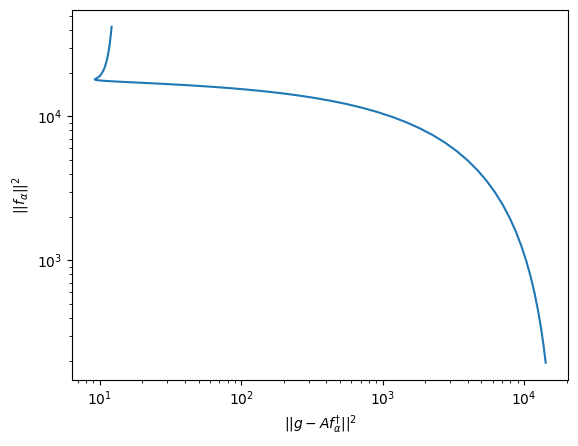

In [752]:
plt.loglog(nr2s, psi_fs)
plt.xlabel('$||g-Af_{\\alpha}^{\\dagger}||^2$')
plt.ylabel('$||f_{\\alpha}||^2$')
plt.show()

In [753]:
X, Y = nr2s, psi_fs
dx = np.gradient(X, X)  # first derivatives
dy = np.gradient(Y, X)

d2x = np.gradient(dx, X)  # second derivatives
d2y = np.gradient(dy, X)

cur = np.abs(d2y) / (np.sqrt(1 + dy ** 2)) ** 1.5  # curvature

In [754]:
idx = np.argmax(cur)
print(alphas[idx])

0.004365158322401665


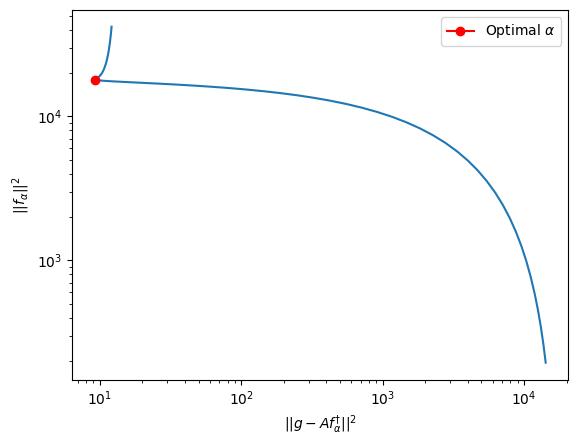

In [757]:
x, y = X[idx], Y[idx]
plt.loglog(X, Y)
plt.loglog(x, y, color='r', marker='o', label='Optimal $\\alpha$')
plt.xlabel('$||g-Af_{\\alpha}^{\\dagger}||^2$')
plt.ylabel('$||f_{\\alpha}||^2$')
plt.legend()
plt.show()

Status: 0
Iteration number: 45
L2D: 12.869227


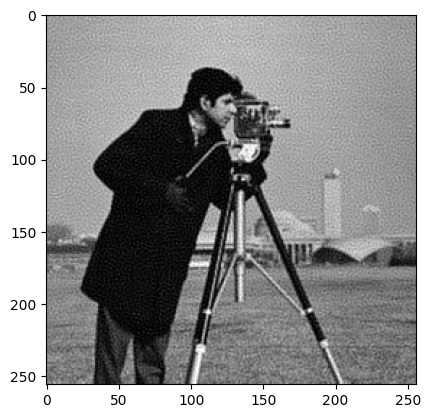

In [759]:
alpha = alphas[idx]
A = scipy.sparse.linalg.LinearOperator((height * width, height * width), ATA)
ATg = gaussian_filter(blur(gray_image, sigma, theta), sigma).reshape((height * width,))
counter = gmres_counter(disp=False)
x2, info = scipy.sparse.linalg.gmres(A, ATg, callback=counter)
f_alpha2 = x2.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (info, counter.niter, np.linalg.norm(f_alpha2 - gray_image)))
plt.imshow(f_alpha2.clip(0, 1), cmap='gray')

Text(0.5, 1.0, '$\\alpha=0.004$ $L2D: 12.87$')

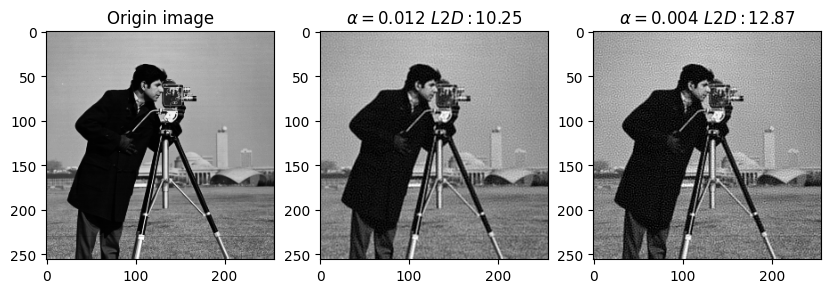

In [762]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(f_alpha1.clip(0, 1), cmap='gray')
ax[1].set_title('$\\alpha=%.3f$ $L2D: %.2f$' % (sol.x, np.linalg.norm(f_alpha1 - gray_image)))
ax[2].imshow(f_alpha2.clip(0, 1), cmap='gray')
ax[2].set_title('$\\alpha=%.3f$ $L2D: %.2f$' % (alphas[idx], np.linalg.norm(f_alpha2 - gray_image)))

## 3. Using a regularisation term based on the spatial derivative

### Part a

In [777]:
N = height
data = np.array([np.ones((N,)), -np.ones((N,))])
diags = np.array([0, 1])
a = scipy.sparse.spdiags(data, diags, N, N)
gxm = scipy.sparse.kron(scipy.sparse.identity(N), a)
gym = scipy.sparse.kron(a, scipy.sparse.identity(N))
lapm = gxm.T @ gxm + gym.T @ gym

In [556]:
def fgx(img):
    img_f = img.reshape((height * width,))
    gx = gxm @ img_f
    return gx.reshape(img.shape)
def fgy(img):
    img_f = img.reshape((height * width,))
    gy = gym @ img_f
    return gy.reshape(img.shape)

Text(0.5, 1.0, '$\\nabla x^T\\nabla x+\\nabla y^T\\nabla y$')

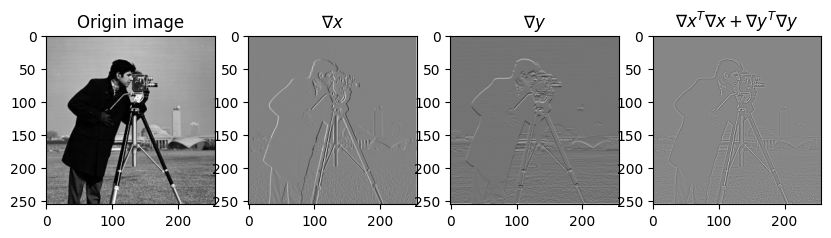

In [784]:
gx, gy = fgx(gray_image), fgy(gray_image)
gamma = np.exp(-np.sqrt(gx * gx + gy * gy) / np.linalg.norm(np.sqrt(gx * gx + gy * gy)))
fig, ax = plt.subplots(1, 4, figsize=(10, 20))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(gx, cmap='gray')
ax[1].set_title('$\\nabla x$')
ax[2].imshow(gy, cmap='gray')
ax[2].set_title('$\\nabla y$')
ax[3].imshow((lapm @ gray_image.reshape((height * width,))).reshape((height, width)), cmap='gray')
ax[3].set_title('$\\nabla x^T\\nabla x+\\nabla y^T\\nabla y$')

### Part b

In [779]:
def ATA_G(v):
    image = v.reshape((height, width))
    ATAf = gaussian_filter(gaussian_filter(image, sigma), sigma)
    DTDf = lapm @ v
    z = ATAf 
    
    return z.reshape(v.shape) + alpha * DTDf

In [780]:
alpha = 1e-7
A = scipy.sparse.linalg.LinearOperator((height * width, height * width), ATA_G)
ATg = gaussian_filter(blur(gray_image, sigma, theta), sigma).reshape((height * width,))
counter = gmres_counter(disp=False)
x, info = scipy.sparse.linalg.gmres(A, ATg, callback=counter)

Status: 0
Iteration number: 1471
L2D: 157.933595


Text(0.5, 1.0, 'Deconvolved image')

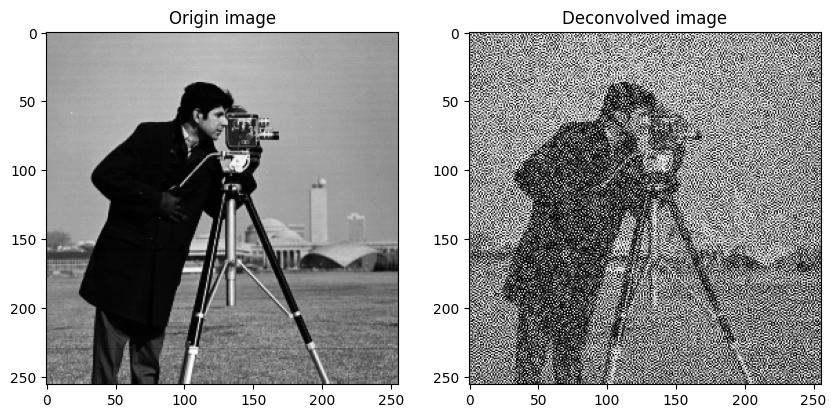

In [782]:
f_alpha = x.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (info, counter.niter, np.linalg.norm(f_alpha - gray_image)))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(f_alpha.clip(0, 1), cmap='gray')
ax[1].set_title('Deconvolved image')

In [855]:
def M_fG(v):
    image = v.reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(v.shape)
    dfx = np.sqrt(alpha) * gxm @ v
    dfy = np.sqrt(alpha) * gym @ v
    z = np.hstack((y, dfx, dfy))

    return z

def MT_bG(v):
    length = height * width
    image = v[: length].reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(length)
    dfxt = np.sqrt(alpha) * v[length: 2 * length] @ gxm.T
    dfyt = np.sqrt(alpha) * v[2 * length:] @ gym.T
    z = y + dfxt + dfyt

    return z

In [856]:
alpha = 0.01
M = scipy.sparse.linalg.LinearOperator((3 * height * width, height * width), matvec=M_fG, rmatvec=MT_bG)
g = blur(gray_image, sigma, theta).reshape((height * width,))
b = np.hstack((g, np.zeros(g.shape), np.zeros(g.shape)))
x_lsqr3b, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(M, b)

Status: 1
Iteration number: 2457
L2D: 12.819445


Text(0.5, 1.0, 'Deconvolved image')

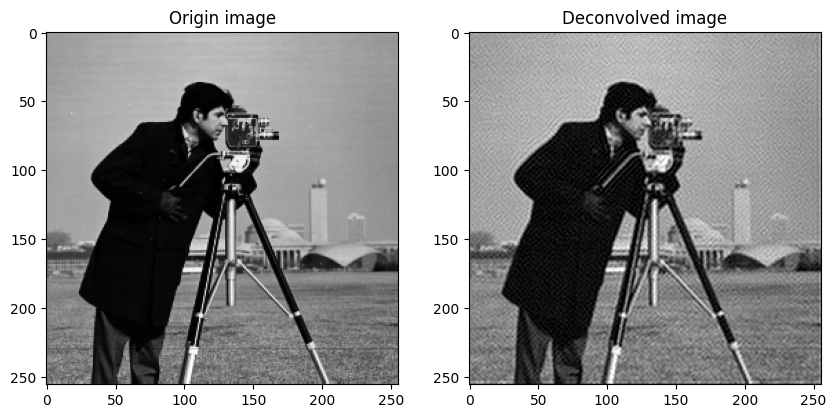

In [857]:
f = x_lsqr3b.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (istop, itn, np.linalg.norm(f - gray_image)))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(f.clip(0, 1), cmap='gray')
ax[1].set_title('Deconvolved image')

### Part c

In [775]:
M = scipy.sparse.linalg.LinearOperator((3 * height * width, height * width), matvec=M_fG, rmatvec=MT_bG)
g = blur(gray_image, sigma, theta).reshape((height * width,))
b = np.hstack((g, np.zeros(g.shape), np.zeros(g.shape)))
def dp_alpha(a):
    global alpha
    alpha = a
    f = scipy.sparse.linalg.lsqr(M, b)
    Af = gaussian_filter(f[0].reshape((height, width)), sigma)
    r_alpha = g - Af.reshape(g.shape)
    nr = np.linalg.norm(r_alpha)
    
    return np.abs(nr * nr / (height * width) - theta * theta)

In [776]:
sol = scipy.optimize.minimize_scalar(dp_alpha, bounds=(1e-6, 1), method='bounded')

In [801]:
print('Converge Message: %s\nOptimal alpha: %.6f\nValue of DP(alpha): %.6e\n' % (sol.message, sol.x, dp_alpha(sol.x)))
alpha = sol.x
x_lsqr = scipy.sparse.linalg.lsqr(M, b)
fg1 = x_lsqr[0].reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (istop, itn, np.linalg.norm(fg1 - gray_image)))
# plt.imshow(fg1.clip(0, 1), cmap='gray')

Converge Message: Solution found.
Optimal alpha: 0.012853
Value of DP(alpha): 6.479852e-08

Status: 1
Iteration number: 2951
L2D: 13.161243


In [585]:
def calLCurvePoint(a):
    global alpha
    alpha = a
    f, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(M, b)
    Af = gaussian_filter(f.reshape((height, width)), sigma)
    r_alpha = g - Af.reshape(g.shape)
    nr = np.linalg.norm(r_alpha)
    nf = np.linalg.norm(f)
    nr2 = nr * nr
    psi_f = nf * nf

    return nr2, psi_f 

def calLCurve(alphas):
    nr2s = []
    psi_fs = []
    t = tqdm(alphas)
    for a in t:
        nr2, psi_f = calLCurvePoint(a)
        nr2s.append(nr2)
        psi_fs.append(psi_f)

    return nr2s, psi_fs

In [796]:
N = 50
alphas = np.logspace(-5, 0, N, endpoint=False)
# y = np.ones(N)
# plt.loglog(alphas, y, '.')
# plt.show()

In [797]:
nr2sG, psi_fsG = calLCurve(alphas)

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


0.003981071705534973


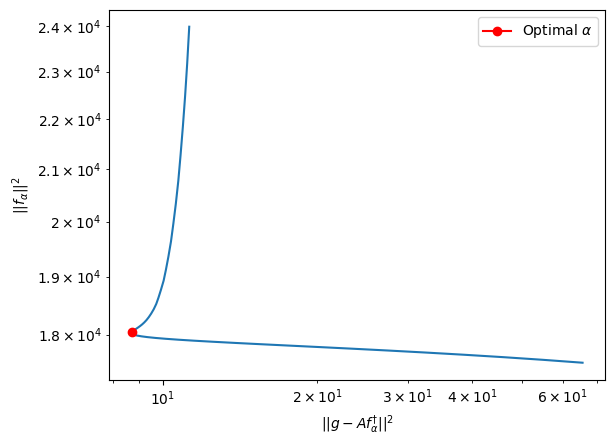

In [798]:
X, Y = nr2sG, psi_fsG
dx = np.gradient(X, X)  # first derivatives
dy = np.gradient(Y, X)

d2x = np.gradient(dx, X)  # second derivatives
d2y = np.gradient(dy, X)

cur = np.abs(d2y) / (np.sqrt(1 + dy ** 2)) ** 1.5  # curvature

idx = np.argmax(cur)
print(alphas[idx])

x, y = X[idx], Y[idx]
plt.loglog(X, Y)
plt.loglog(x, y, color='r', marker='o', label='Optimal $\\alpha$')
plt.xlabel('$||g-Af_{\\alpha}^{\\dagger}||^2$')
plt.ylabel('$||f_{\\alpha}||^2$')
plt.legend()
plt.show()

In [799]:
M = scipy.sparse.linalg.LinearOperator((3 * height * width, height * width), matvec=M_fG, rmatvec=MT_bG)
g = blur(gray_image, sigma, theta).reshape((height * width,))
b = np.hstack((g, np.zeros(g.shape), np.zeros(g.shape)))
alpha = alphas[idx]
x_lsqr, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(M, b)
fg2 = x_lsqr.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (istop, itn, np.linalg.norm(fg2 - gray_image)))
# plt.imshow(fg2.clip(0, 1), cmap='gray')

Status: 1
Iteration number: 2951
L2D: 13.622716


Text(0.5, 1.0, '$\\alpha=0.004$ $L2D: 13.62$')

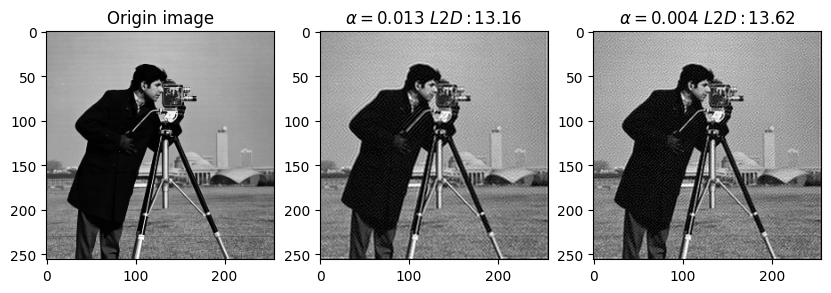

In [802]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Origin image')
ax[1].imshow(fg1.clip(0, 1), cmap='gray')
ax[1].set_title('$\\alpha=%.3f$ $L2D: %.2f$' % (sol.x, np.linalg.norm(fg1 - gray_image)))
ax[2].imshow(fg2.clip(0, 1), cmap='gray')
ax[2].set_title('$\\alpha=%.3f$ $L2D: %.2f$' % (alphas[idx], np.linalg.norm(fg2 - gray_image)))

## 4. Construct an anisotropic derivative filter

In [840]:
blurred = blur(gray_image, sigma, theta)
gx, gy = fgx(blurred), fgy(blurred)
scalar = 1
T = scalar * np.linalg.norm(np.sqrt(gx * gx + gy * gy))
print(T)
gamma_x = np.exp(-gx / T).reshape((height * width,))
data = np.array([gamma_x])
diags = np.array([0])
gamma_x_sp = scipy.sparse.spdiags(data, diags, height * width, height * width)

gamma_y = np.exp(-gy / T).reshape((height * width,))
data = np.array([gamma_y])
diags = np.array([0])
gamma_y_sp = scipy.sparse.spdiags(data, diags, height * width, height * width)

gxm_gamma = np.sqrt(gamma_x_sp) @ gxm
gym_gamma = np.sqrt(gamma_y_sp) @ gym

17.587901561686465


In [841]:
def M_fG(v):
    image = v.reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(v.shape)
    dfx = np.sqrt(alpha) * gxm_gamma @ v
    dfy = np.sqrt(alpha) * gym_gamma @ v
    z = np.hstack((y, dfx, dfy))

    return z

def MT_bG(v):
    length = height * width
    image = v[: length].reshape((height, width))
    y = gaussian_filter(image, sigma).reshape(length)
    dfxt = np.sqrt(alpha) * v[length: 2 * length] @ gxm_gamma.T
    dfyt = np.sqrt(alpha) * v[2 * length:] @ gym_gamma.T
    z = y + dfxt + dfyt

    return z

In [842]:
alpha = 0.013
M = scipy.sparse.linalg.LinearOperator((3 * height * width, height * width), matvec=M_fG, rmatvec=MT_bG)
g = blur(gray_image, sigma, theta).reshape((height * width,))
b = np.hstack((g, np.zeros(g.shape), np.zeros(g.shape)))
x_lsqr, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(M, b)

Status: 1
Iteration number: 2366
L2D: 12.985544


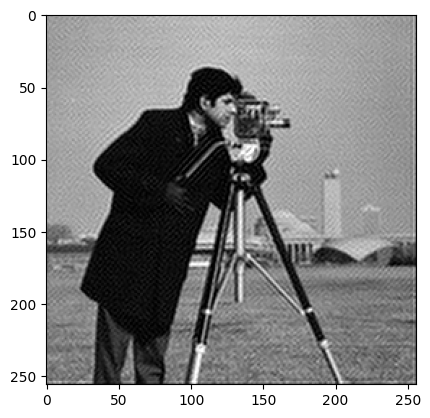

In [843]:
f = x_lsqr.reshape((height, width))
print('Status: %d\nIteration number: %d\nL2D: %.6f' % (istop, itn, np.linalg.norm(f - gray_image)))
plt.imshow(f.clip(0, 1), cmap='gray')

In [844]:
blurred = blur(gray_image, sigma, theta)
f = blurred.reshape(height * width)
alpha = 0.013
old_f = f
opt_f = 10 * f
cnt = 1
res = []
for i in range(30):
    gx, gy = fgx(f), fgy(f)
    scalar = 0.1

    gamma_x = np.exp(-gx / scalar / np.max(gx)).reshape((height * width,))
    data = np.array([gamma_x])
    diags = np.array([0])
    gamma_x_sp = scipy.sparse.spdiags(data, diags, height * width, height * width)

    gamma_y = np.exp(-gy / scalar / np.max(gy)).reshape((height * width,))
    data = np.array([gamma_y])
    diags = np.array([0])
    gamma_y_sp = scipy.sparse.spdiags(data, diags, height * width, height * width)

    gxm_gamma = np.sqrt(gamma_x_sp) @ gxm
    gym_gamma = np.sqrt(gamma_y_sp) @ gym
    f, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = scipy.sparse.linalg.lsqr(M, b)
    print("iter: %d" % cnt)
    print("Change: %.6f" % np.linalg.norm(f - old_f))
    print("L2D: %.6f" % np.linalg.norm(f - gray_image.reshape(height * width)))
    res.append(f)
    if np.linalg.norm(f - gray_image.reshape(height * width)) < np.linalg.norm(opt_f - gray_image.reshape(height * width)):
        opt_f = f
    if np.linalg.norm(f - old_f) < 1:
        break
    old_f = f
    cnt += 1

iter: 1
Change: 14.955279
L2D: 15.657859
iter: 2
Change: 10.620152
L2D: 13.004772
iter: 3
Change: 8.902768
L2D: 15.009329
iter: 4
Change: 8.612714
L2D: 13.669740
iter: 5
Change: 9.186902
L2D: 15.291103
iter: 6
Change: 9.447126
L2D: 13.860691
iter: 7
Change: 9.326659
L2D: 15.225157
iter: 8
Change: 12.776563
L2D: 14.822997
iter: 9
Change: 12.859101
L2D: 12.763790
iter: 10
Change: 15.722664
L2D: 17.506132
iter: 11
Change: 15.682756
L2D: 13.130993
iter: 12
Change: 13.953438
L2D: 16.556366
iter: 13
Change: 11.059970
L2D: 12.755403
iter: 14
Change: 11.535039
L2D: 16.039307
iter: 15
Change: 14.735768
L2D: 14.205327
iter: 16
Change: 13.049808
L2D: 15.129876
iter: 17
Change: 9.706659
L2D: 13.351418
iter: 18
Change: 10.135341
L2D: 12.494500
iter: 19
Change: 11.674416
L2D: 15.172191
iter: 20
Change: 14.027712
L2D: 14.456958
iter: 21
Change: 13.238159
L2D: 15.319168
iter: 22
Change: 10.667561
L2D: 12.771892
iter: 23
Change: 10.081584
L2D: 14.542698
iter: 24
Change: 9.457322
L2D: 14.233467
iter: 25

L2D: 12.494500


Text(0.5, 1.0, 'Anisotropic derivative filter')

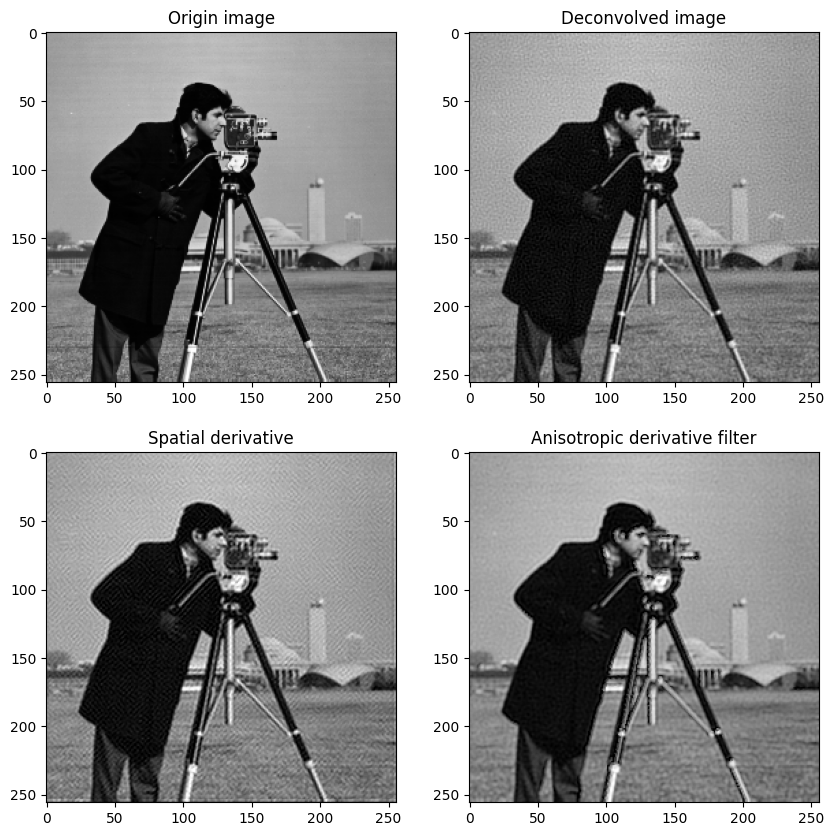

In [859]:
f_alpha = opt_f.reshape((height, width))
print('L2D: %.6f' % (np.linalg.norm(f_alpha - gray_image)))
#plt.imshow(f_alpha.clip(0, 1), cmap='gray')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(gray_image, cmap='gray')
ax[0, 0].set_title('Origin image')
f_alpha1 = x1c.reshape((height, width))
ax[0, 1].imshow(f_alpha1.clip(0, 1), cmap='gray')
ax[0, 1].set_title('Deconvolved image')
f_alpha2 = x_lsqr3b.reshape((height, width))
ax[1, 0].imshow(f_alpha2.clip(0, 1), cmap='gray')
ax[1, 0].set_title('Spatial derivative')
ax[1, 1].imshow(f_alpha.clip(0, 1), cmap='gray')
ax[1, 1].set_title('Anisotropic derivative filter')